# Graphical Model Testing: Similarity Implementations

Using the [NetworkX](https://networkx.github.io/) library.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## Graphical Model Setup

In [2]:
DG = nx.DiGraph() # creates directed graph
DG.add_node("rain")
DG.add_node("sprinkler")
DG.add_node("water fountain")
DG.add_node("grass wet")
DG.add_node("sidewalk wet")
DG.add_node("road wet")
DG.add_node("person slipped")
DG.add_node("grass healthy")

In [3]:
edge_list = [("rain", "grass wet", 0.9), ("rain", "sidewalk wet", 0.75), ("rain", "road wet", 0.8), ("sprinkler", "grass wet", 0.8), ("sprinkler", "sidewalk wet", 0.7), ("water fountain", "sidewalk wet", 0.1), ("sidewalk wet", "person slipped", 0.8), ("road wet", "person slipped", 0.3), ("grass wet", "grass healthy", 0.8)]
DG.add_weighted_edges_from(edge_list) # adds edges to graph
list(DG.edges)

[('rain', 'grass wet'),
 ('rain', 'sidewalk wet'),
 ('rain', 'road wet'),
 ('sprinkler', 'grass wet'),
 ('sprinkler', 'sidewalk wet'),
 ('water fountain', 'sidewalk wet'),
 ('grass wet', 'grass healthy'),
 ('sidewalk wet', 'person slipped'),
 ('road wet', 'person slipped')]

In [4]:
DG.number_of_nodes()

8

In [5]:
list(DG.nodes)

['rain',
 'sprinkler',
 'water fountain',
 'grass wet',
 'sidewalk wet',
 'road wet',
 'person slipped',
 'grass healthy']

In [6]:
list(DG.neighbors("rain"))
list(DG.neighbors("grass wet"))

['grass healthy']

In [7]:
# returns list of edges from the input node
list(DG.out_edges("rain")) 

[('rain', 'grass wet'), ('rain', 'sidewalk wet'), ('rain', 'road wet')]

In [8]:
nx.descendants(DG, "rain") # includes indirect descendants of a node

{'grass healthy', 'grass wet', 'person slipped', 'road wet', 'sidewalk wet'}

In [9]:
# returns all edges in grpah
nx.edges(DG)

OutEdgeView([('rain', 'grass wet'), ('rain', 'sidewalk wet'), ('rain', 'road wet'), ('sprinkler', 'grass wet'), ('sprinkler', 'sidewalk wet'), ('water fountain', 'sidewalk wet'), ('grass wet', 'grass healthy'), ('sidewalk wet', 'person slipped'), ('road wet', 'person slipped')])

In [10]:
# returns each edge's weight
nx.get_edge_attributes(DG, 'weight')

{('rain', 'grass wet'): 0.9,
 ('rain', 'sidewalk wet'): 0.75,
 ('rain', 'road wet'): 0.8,
 ('sprinkler', 'grass wet'): 0.8,
 ('sprinkler', 'sidewalk wet'): 0.7,
 ('water fountain', 'sidewalk wet'): 0.1,
 ('grass wet', 'grass healthy'): 0.8,
 ('sidewalk wet', 'person slipped'): 0.8,
 ('road wet', 'person slipped'): 0.3}

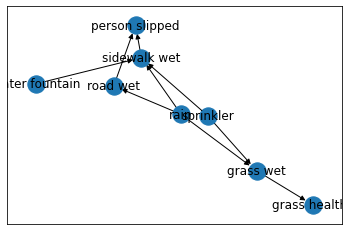

In [11]:
# displays the graph
nx.draw_networkx(DG)

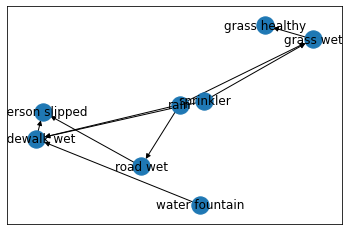

In [12]:
nx.draw_networkx(DG)

In [13]:
print(DG.out_edges("rain"))

[('rain', 'grass wet'), ('rain', 'sidewalk wet'), ('rain', 'road wet')]


## Similarity Implementation: Edit-Distance

In [14]:
# Returns all children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [15]:
a = get_children(DG, "rain")
a

{'grass wet': 0.9, 'sidewalk wet': 0.75, 'road wet': 0.8}

Edit-distance based similarity implementation, only based on a node's direct children.

In [16]:
# Returns the similarity of node B compared to node A
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    
    return cost / len(A_children)

In [17]:
get_immediate_similarity(DG, "rain", "sprinkler")

0.3833333333333333

In [18]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

In [19]:
most_similar_node = find_most_immediate_similar(DG, "rain")
most_similar_node

'sprinkler'

In [20]:
nodes = list(DG.nodes)
nodes.remove("rain")

for node in nodes:
    node_similarity = get_immediate_similarity(DG, "rain", node)
    print("Node:", node)
    print("Similarity:", node_similarity)
    print()

Node: sprinkler
Similarity: 0.3833333333333333

Node: water fountain
Similarity: 0.8833333333333333

Node: grass wet
Similarity: 1.0

Node: sidewalk wet
Similarity: 1.0

Node: road wet
Similarity: 1.0

Node: person slipped
Similarity: 1.0

Node: grass healthy
Similarity: 1.0



Edit-distance based similarity implementation, based on all descendants of a node.

In [21]:
# (Adapted from Meg's notebook)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [22]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    return cost / len(A_children)

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [23]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

In [24]:
most_similar_node = find_most_similar(DG, "rain")
most_similar_node

'sprinkler'

In [25]:
nodes = list(DG.nodes)
nodes.remove("rain")

for node in nodes:
    node_similarity = get_full_similarity(DG, "rain", node)
    print("Node:", node)
    print("Similarity:", node_similarity)
    print()

Node: sprinkler
Similarity: 0.30999999999999994

Node: water fountain
Similarity: 0.762

Node: grass wet
Similarity: 0.8160000000000001

Node: sidewalk wet
Similarity: 0.9120000000000001

Node: road wet
Similarity: 0.812

Node: person slipped
Similarity: 1.0

Node: grass healthy
Similarity: 1.0



In [26]:
children = get_descendants(DG, "rain")
children

{'grass wet': 0.9,
 'grass healthy': 0.7200000000000001,
 'sidewalk wet': 0.75,
 'person slipped': 0.24,
 'road wet': 0.8}

In [27]:
sprinkler_descendants = get_descendants(DG, "sprinkler")
sprinkler_descendants

{'grass wet': 0.8,
 'grass healthy': 0.6400000000000001,
 'sidewalk wet': 0.7,
 'person slipped': 0.5599999999999999,
 'road wet': 0.8}

In [28]:
rain_sprinkler_similarity = get_full_similarity(DG, "rain", "sprinkler")
rain_sprinkler_similarity

0.30999999999999994